# Задача 3. Сравнение методов классификации

- Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pathlib

# устанавливаем точность чисел с плавающей точкой
%precision % .4f

import warnings

warnings.filterwarnings('ignore')  # отключаем предупреждения
dataset_path = pathlib.Path().resolve().parent / "data" / "heart_disease" / "heart.csv"

### Датасет
Будет использоваться [Датасет](https://github.com/rustam-azimov/ml-course/blob/main/data/heart_disease/heart.csv). Набор содержит данные заболевания сердца

### Признаки
age - возраст в годах\
sex - пол (1 - мужской, 0 - женский)\
cp - тип боли в груди\
trestbps - артериальное давление в состоянии покоя (в мм рт.ст. при поступлении в больницу)\
chol - уровень холестерина в сыворотке крови в мг/дл\
fbs - (уровень сахара в крови натощак > 120 мг/дл) (1 = верно; 0 = ложно)\
restecg - результаты электрокардиографии в состоянии покоя\
thalach - достигнута максимальная частота сердечных сокращений\
exang - стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)\
oldpeak - Депрессия ST, вызванная физической нагрузкой по сравнению с отдыхом\
slope - наклон сегмента ST пикового упражнения\
ca - количество крупных сосудов (0-3), окрашенных методом флуороскопии\
thal - 3 = нормальный; 6 = исправленный дефект; 7 = обратимый дефект\
target - есть заболевание или нет (1=да, 0=нет))


In [2]:
df = pd.read_csv(dataset_path)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Нулевых значений нет

## EDA

In [4]:
df["target"].value_counts()

target
1    526
0    499
Name: count, dtype: int64

Датасет сбалансирован. Целевой признак одинаково распределён

### Сравним частоту сердечного заболевания среди мужчин и женщин

In [5]:
df["sex"].value_counts()

sex
1    713
0    312
Name: count, dtype: int64

Заметим, что мужчин больше чем в два раза больше, чем женщин

<Axes: xlabel='sex', ylabel='target'>

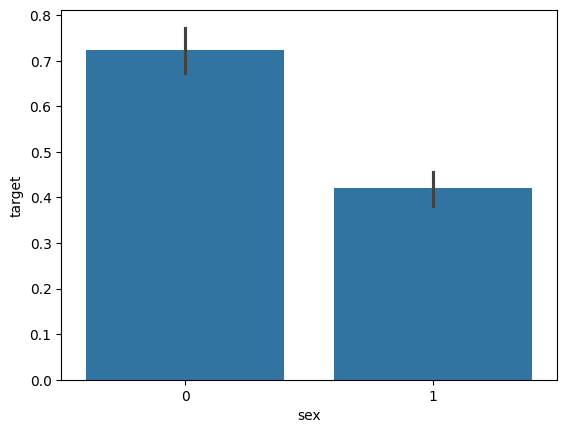

In [6]:
sns.barplot(x='sex', y="target", data=df)

Однако, у женщин чаще встречается заболевание сердца

### Сравним частоту сердечного заболевания от возраста

<Axes: xlabel='target', ylabel='age'>

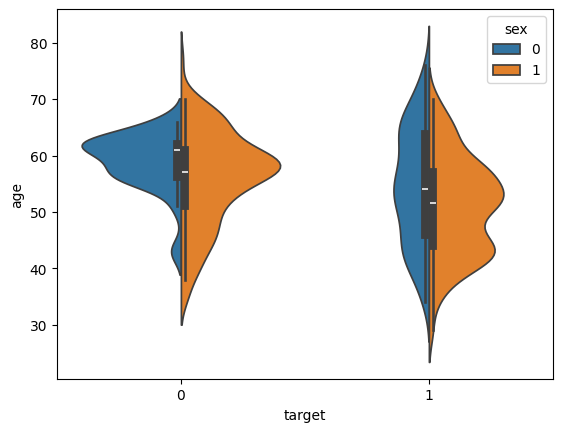

In [7]:
sns.violinplot(x="target", y="age", hue="sex", data=df, split=True)

Можно заметить, что большинство заболеваний случаются в возрасте 40-55 лет

### Посторим корреляционную матрицу

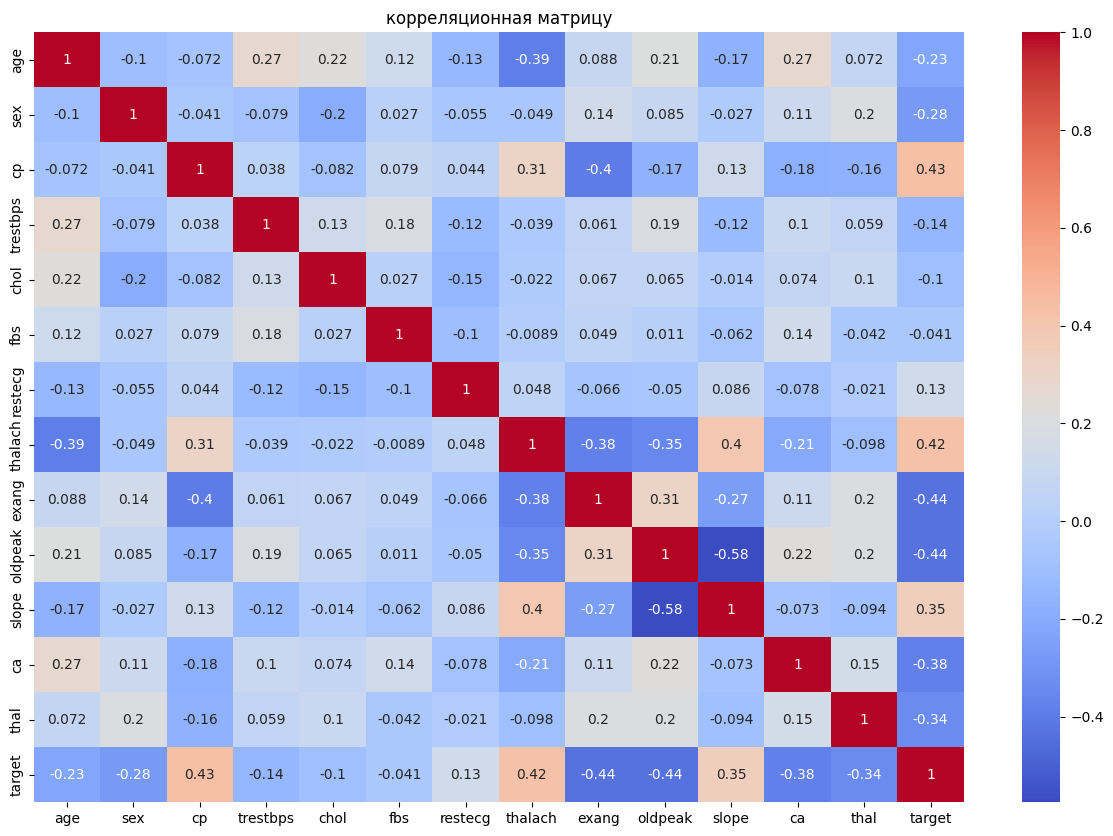

In [8]:
df_corr = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=True, cmap="coolwarm")
plt.title("корреляционная матрицу")
plt.show()

# Реализация

## KNN Classifier

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n = 3):
        self.n = n

    def fit(self, X, y):
        self.X_, self.y_ = check_X_y(X, y)
        return self

    def predict(self, X):
        X = check_array(X)

        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            n_neighbor_classes = self.y_[sorted_dists_idx][:self.n]
            elems, counts = np.unique(n_neighbor_classes, return_counts=True)
            result[i] = elems[np.argmax(counts)]

        return result

## Разделение выборки

In [10]:
from sklearn.model_selection import train_test_split

X= df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Масштабирование данных

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns =X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

## Подбор признаков

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

rfe = RFECV(
    estimator=LogisticRegression()
).fit(X_train, y_train)

feats = list(X_train.columns[rfe.support_])

print(f"Количество признаков: {rfe.n_features_}")
print(f"{feats}")

Количество признаков: 9
['sex', 'cp', 'chol', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [13]:
X_train = X_train[feats]
X_test = X_test[feats]

## Подбор гипермараметров

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

def train(model, grid, scoring):
    grid_search = GridSearchCV(model, grid, scoring=scoring)
    grid_search.fit(X_train, y_train)
    print(f"Grid best params: {str(grid_search.best_params_)}")
    print(f"Grid best score: {grid_search.best_score_}")

    cmd = ConfusionMatrixDisplay.from_estimator(
        grid_search.best_estimator_,
        X_test,
        y_test,
        cmap=plt.cm.Blues
    )
    ax = cmd.ax_

    ax.set_title("Confusion matrix")
    ax.plot()

Grid best params: {'n': 2}
Grid best score: nan


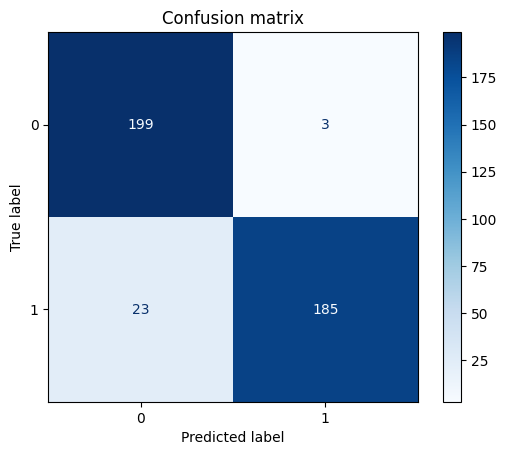

In [15]:
train(
    KNNClassifier(),
    {"n": [i for i in range(2, 20, 1)]},
    "recall"
)

Grid best params: {'C': 0.2, 'max_iter': 200, 'tol': 1e-05}
Grid best score: 0.902579365079365


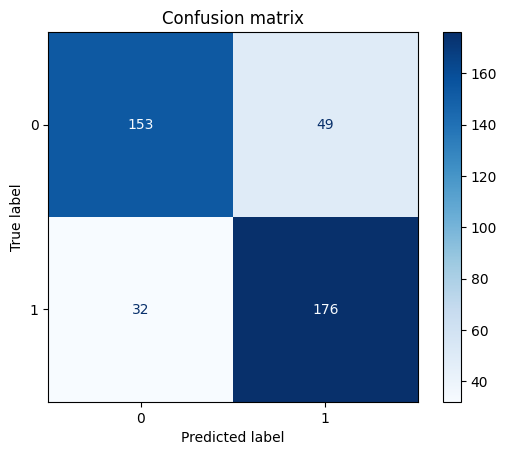

In [16]:
train(
    LogisticRegression(),
    {
        "tol": [1e-5, 1e-4, 1e-3],
        "C": [0.2, 0.4, 0.6, 1],
        "max_iter": [200, 400, 600]
    },
    "recall"
)

Grid best params: {'C': 0.5, 'coef0': 0, 'gamma': 'scale', 'kernel': 'linear', 'tol': 1e-05}
Grid best score: 0.8710311143068076


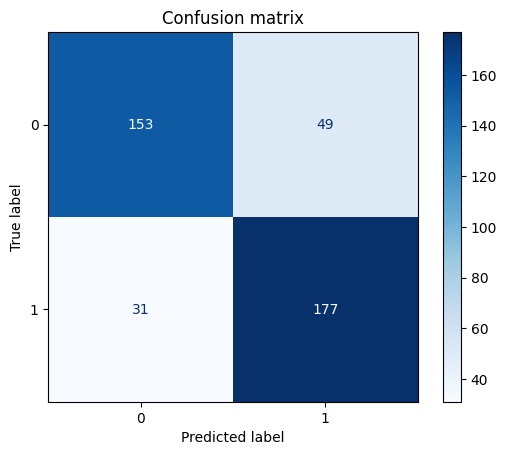

In [17]:
from sklearn.svm import SVC

train(
    SVC(),
    {
        "C": [0.5, 0.5, 1],
        "kernel": ["linear", "sigmoid"],
        "gamma": ["scale", "auto"],
        "coef0": [0, 1],
        "tol": [1e-5, 1e-3],
    },
    "f1"
)

Grid best params: {'n_neighbors': 2}
Grid best score: 0.8804067460317461


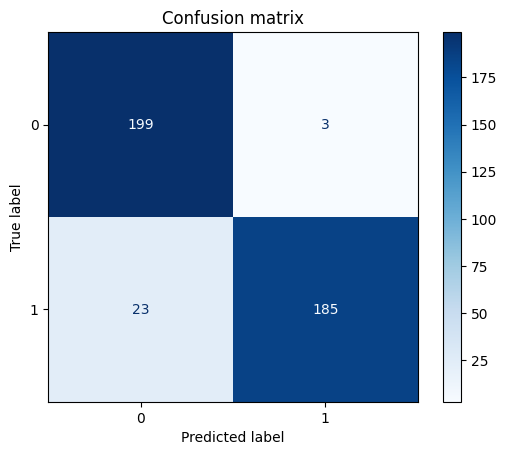

In [18]:
from sklearn.neighbors import KNeighborsClassifier

train(
    KNeighborsClassifier(),
    {"n_neighbors": [2, 5, 8]},
    "recall"
)

Grid best params: {'var_smoothing': 0.0001}
Grid best score: 0.8554563492063492


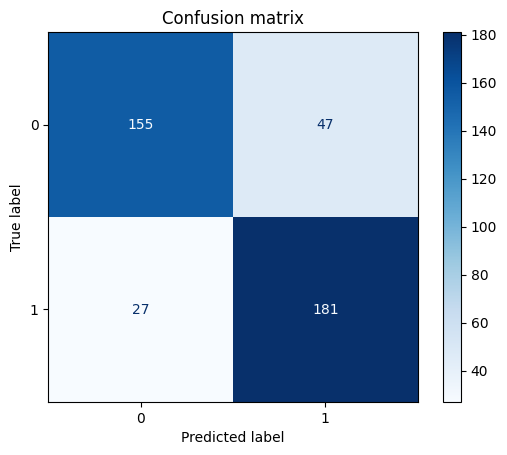

In [19]:
from sklearn.naive_bayes import GaussianNB

train(
    GaussianNB(),
    {"var_smoothing": [1e-4,1e-5,1e-6]},
    "recall"
)

Grid best params: {'criterion': 'log_loss', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Grid best score: 0.9749503968253969


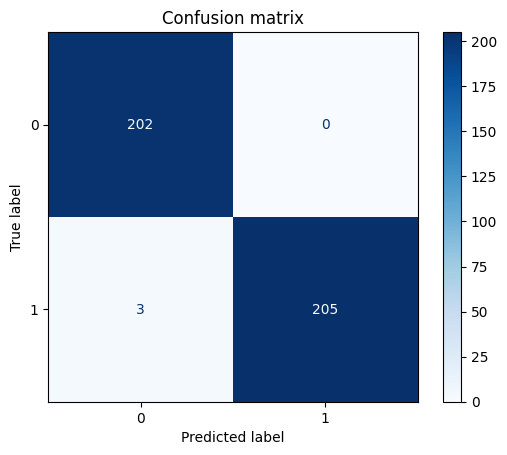

In [20]:
from sklearn.tree import DecisionTreeClassifier

train(
    DecisionTreeClassifier(),
    {
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [2, 3, 4, 5, 10, 20],
        "min_samples_split": [2, 4, 5, 10],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": [2, 4, 6, 8],
    },
    "recall"
)

# Выводы

KNN классификаторы и DecisionTree показали себя лучше всех с меньшими false positive